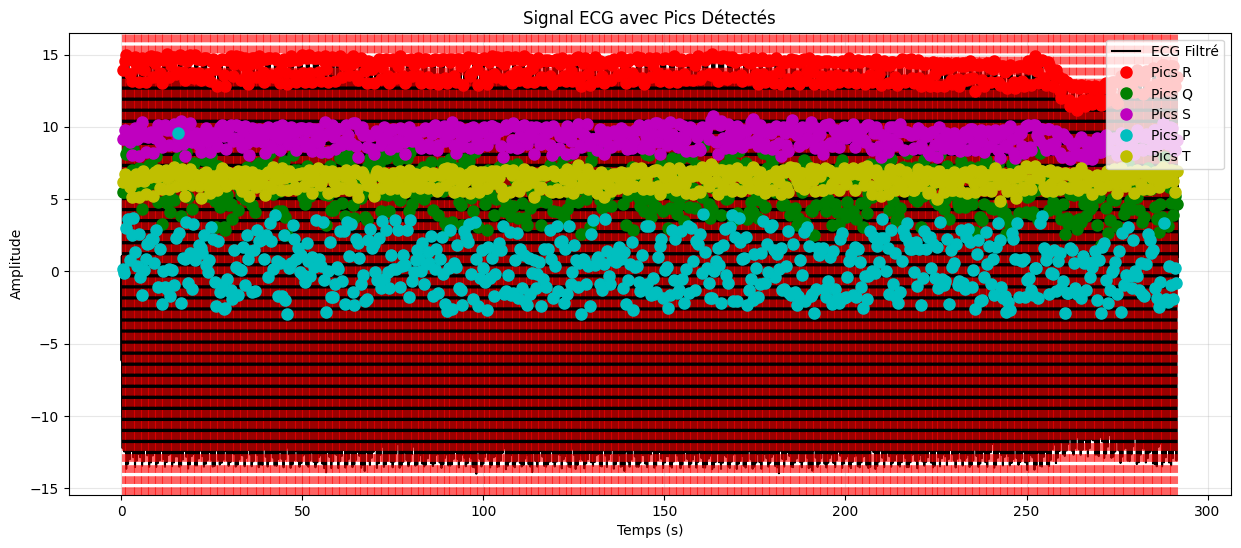

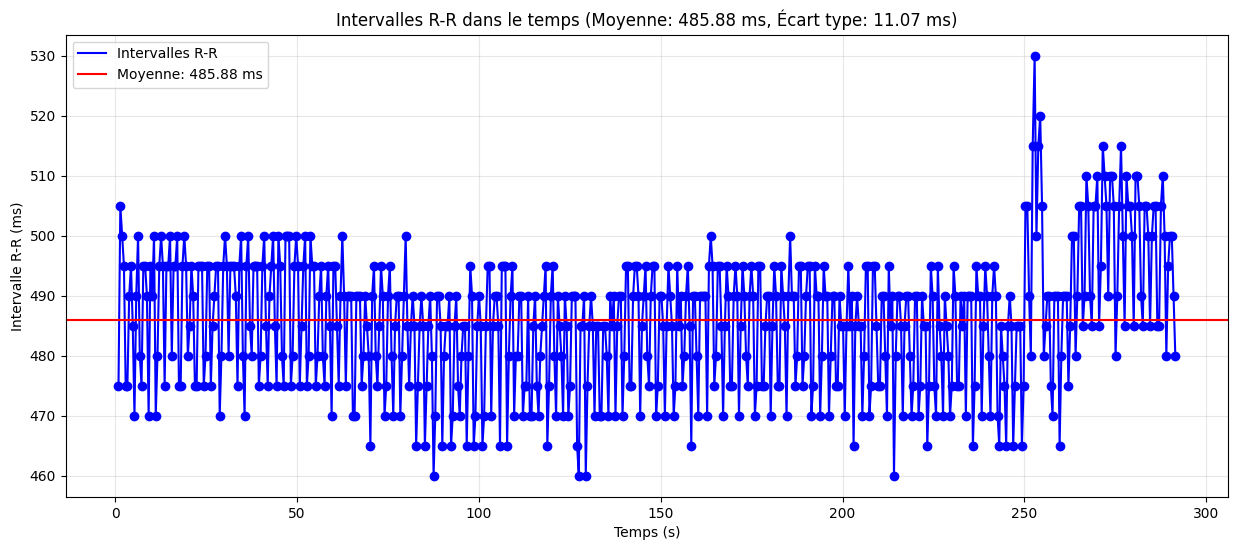

Indices des pics R (échantillons): [   87   182   283   383   482   577   672   770   869   966  1060  1158
  1258  1354  1449  1548  1647  1745  1839  1938  2036  2136  2230  2326
  2425  2525  2624  2719  2818  2917  3017  3113  3212  3311  3411  3506
  3601  3700  3800  3899  3995  4092  4191  4289  4384  4479  4578  4677
  4776  4871  4967  5066  5165  5260  5357  5455  5554  5653  5747  5843
  5942  6042  6141  6237  6336  6435  6534  6632  6727  6826  6926  7022
  7116  7215  7315  7412  7508  7607  7706  7805  7900  7996  8095  8195
  8292  8387  8485  8584  8684  8781  8876  8976  9075  9171  9266  9366
  9466  9566  9661  9757  9856  9956 10055 10150 10247 10346 10446 10541
 10637 10737 10836 10935 11030 11126 11224 11323 11419 11514 11612 11711
 11808 11902 12001 12100 12197 12292 12390 12490 12588 12683 12781 12879
 12977 13071 13165 13263 13361 13459 13554 13650 13748 13845 13941 14034
 14132 14231 14327 14422 14519 14618 14716 14810 14905 15003 15102 15198
 15292 15389 154

In [2]:
import pandas as pd
import numpy as np
import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt

def charger_donnees(fichier, encodage='latin1'):
    """
    Charge les données ECG à partir d'un fichier.
    
    Args:
        fichier: Chemin vers le fichier de données
        encodage: Encodage du fichier (par défaut 'latin1' qui fonctionne souvent pour les fichiers européens)
    """
    try:
        data = pd.read_csv(fichier, sep="\t", header=None, decimal=',', encoding=encodage)
        # Suppose que le signal ECG est dans la deuxième colonne (index 1)
        return data.iloc[:, 1].values
    except UnicodeDecodeError:
        # Si l'encodage par défaut échoue, essayer d'autres encodages courants
        encodages_possibles = ['cp1252', 'ISO-8859-1', 'utf-16', 'utf-8-sig']
        for enc in encodages_possibles:
            try:
                print(f"Tentative avec l'encodage {enc}...")
                data = pd.read_csv(fichier, sep="\t", header=None, decimal=',', encoding=enc)
                return data.iloc[:, 1].values
            except UnicodeDecodeError:
                continue
        
        # Si tous les encodages échouent, essayer de lire en mode binaire
        print("Tentative de lecture en mode binaire...")
        import numpy as np
        try:
            # Essayer de charger comme un fichier binaire
            data = np.loadtxt(fichier, delimiter='\t', usecols=[1])
            return data
        except:
            raise ValueError(f"Impossible de lire le fichier {fichier} avec les encodages courants")

def traiter_signal(signal, frequence_echantillonnage):
    """Traite le signal ECG et détecte les pics R."""
    out = ecg.ecg(signal=signal, sampling_rate=frequence_echantillonnage, show=False)
    return out['filtered'], out['rpeaks']

def detecter_tous_pics(signal_filtre, pics_r, frequence_echantillonnage):
    """Détecte tous les pics P, Q, S et T."""
    # Définir les fenêtres heuristiques (en secondes)
    fenetre_q = int(0.05 * frequence_echantillonnage)  # 50 ms avant R pour détection Q
    fenetre_s = int(0.05 * frequence_echantillonnage)  # 50 ms après R pour détection S
    fenetre_p = int(0.15 * frequence_echantillonnage)  # 150 ms avant Q pour détection P
    
    pics_p, pics_q, pics_s, pics_t = [], [], [], []
    
    # Itérer sur chaque pic R
    for i, r in enumerate(pics_r):
        # Pic Q
        debut_q = max(r - fenetre_q, 0)
        fin_q = r
        indice_q = np.argmin(signal_filtre[debut_q:fin_q]) + debut_q
        pics_q.append(indice_q)
        
        # Pic S
        debut_s = r
        fin_s = min(r + fenetre_s, len(signal_filtre))
        indice_s = np.argmin(signal_filtre[debut_s:fin_s]) + debut_s
        pics_s.append(indice_s)
        
        # Pic P
        debut_p = max(indice_q - fenetre_p, 0)
        fin_p = indice_q
        indice_p = np.argmax(signal_filtre[debut_p:fin_p]) + debut_p
        pics_p.append(indice_p)
        
        # Pic T
        if i < len(pics_r) - 1:
            prochain_r = pics_r[i+1]
        else:
            prochain_r = len(signal_filtre)
        decalage_t = int(0.02 * frequence_echantillonnage)  # 20 ms de décalage
        marge = int(0.05 * frequence_echantillonnage)      # 50 ms de marge
        debut_t = indice_s + decalage_t
        fin_t = max(prochain_r - marge, debut_t + 1)
        indice_t = np.argmax(signal_filtre[debut_t:fin_t]) + debut_t
        pics_t.append(indice_t)
    
    return pics_p, pics_q, pics_s, pics_t

def calculer_intervalles_ecg(pics_p, pics_q, pics_r, pics_s, pics_t, frequence_echantillonnage):
    """
    Calcule les intervalles importants de l'ECG:
    - PR: de P à R
    - QRS: de Q à S (durée du complexe QRS)
    - QT: de Q à T
    - PT: de P à T (cycle électrique complet)
    - RR: de R à R (déjà calculé ailleurs)
    """
    intervalles = {
        'PR_ms': [],     # Intervalle PR (de l'onde P au pic R)
        'QRS_ms': [],    # Durée du complexe QRS (de Q à S)
        'QT_ms': [],     # Intervalle QT (de Q à la fin de T)
        'PT_ms': [],     # Intervalle P-T (cycle électrique complet)
        'PQ_ms': [],     # Intervalle P-Q
        'RT_ms': []      # Intervalle R-T
    }
    
    # Assurer que tous les tableaux ont la même longueur
    min_len = min(len(pics_p), len(pics_q), len(pics_r), len(pics_s), len(pics_t))
    
    # Convertir les indices en temps (ms)
    for i in range(min_len):
        # Calcul des intervalles en nombre d'échantillons puis conversion en millisecondes
        pr_samples = pics_r[i] - pics_p[i]
        qrs_samples = pics_s[i] - pics_q[i]
        qt_samples = pics_t[i] - pics_q[i]
        pt_samples = pics_t[i] - pics_p[i]
        pq_samples = pics_q[i] - pics_p[i]
        rt_samples = pics_t[i] - pics_r[i]
        
        # Conversion en millisecondes (ms)
        intervalles['PR_ms'].append((pr_samples / frequence_echantillonnage) * 1000)
        intervalles['QRS_ms'].append((qrs_samples / frequence_echantillonnage) * 1000)
        intervalles['QT_ms'].append((qt_samples / frequence_echantillonnage) * 1000)
        intervalles['PT_ms'].append((pt_samples / frequence_echantillonnage) * 1000)
        intervalles['PQ_ms'].append((pq_samples / frequence_echantillonnage) * 1000)
        intervalles['RT_ms'].append((rt_samples / frequence_echantillonnage) * 1000)
    
    # Calculer les statistiques pour chaque intervalle
    stats_intervalles = {}
    for intervalle, valeurs in intervalles.items():
        if valeurs:  # Vérifier que la liste n'est pas vide
            stats_intervalles[intervalle] = {
                'moyenne': np.mean(valeurs),
                'ecart_type': np.std(valeurs),
                'minimum': np.min(valeurs),
                'maximum': np.max(valeurs)
            }
    
    return intervalles, stats_intervalles

def calculer_intervalle_rr(pics_r, frequence_echantillonnage):
    """Calcule les intervalles R-R et les statistiques associées."""
    # Calculer la distance entre les pics R consécutifs en échantillons
    intervalles_rr_echantillons = np.diff(pics_r)
    
    # Convertir en temps (secondes)
    intervalles_rr_secondes = intervalles_rr_echantillons / frequence_echantillonnage
    
    # Convertir en millisecondes pour une meilleure lisibilité
    intervalles_rr_ms = intervalles_rr_secondes * 1000
    
    # Calculer la fréquence cardiaque à partir des intervalles RR (battements par minute)
    frequence_cardiaque = 60 / intervalles_rr_secondes
    
    # Calculer les statistiques
    stats = {
        'moyenne': np.mean(intervalles_rr_ms),
        'ecart_type': np.std(intervalles_rr_ms),
        'minimum': np.min(intervalles_rr_ms),
        'maximum': np.max(intervalles_rr_ms),
        'frequence_moyenne': 60000 / np.mean(intervalles_rr_ms)
    }
    
    return intervalles_rr_ms, frequence_cardiaque, stats

def calculer_metriques_hrv(intervalles_rr_ms):
    """Calcule les métriques de variabilité de la fréquence cardiaque."""
    nn_intervalles = intervalles_rr_ms  # Intervalles Normal-à-Normal (identiques aux RR pour cette analyse)
    sdnn = np.std(nn_intervalles)  # Écart-type des intervalles NN
    rmssd = np.sqrt(np.mean(np.square(np.diff(nn_intervalles))))  # Racine carrée moyenne des différences successives
    nn50 = sum(abs(np.diff(nn_intervalles)) > 50)  # Nombre d'intervalles NN adjacents qui diffèrent de plus de 50 ms
    pnn50 = (nn50 / len(np.diff(nn_intervalles))) * 100  # Pourcentage de NN50
    
    return {
        'SDNN': sdnn,
        'RMSSD': rmssd,
        'NN50': nn50,
        'pNN50': pnn50
    }

def afficher_signal_ecg(temps, signal_filtre, pics_r, pics_p, pics_q, pics_s, pics_t, frequence_echantillonnage):
    """Affiche le signal ECG avec les pics détectés."""
    plt.figure(figsize=(15, 6))
    plt.plot(temps, signal_filtre, label="ECG Filtré", color="black")
    
    # Ajouter des lignes verticales pour les pics
    for pic in pics_r:
        plt.axvline(pic/frequence_echantillonnage, color='red', linestyle='--', alpha=0.6)
    
    # Afficher les points détectés avec des cercles (pas des carrés)
    plt.plot(np.array(pics_r)/frequence_echantillonnage, signal_filtre[pics_r], 'ro', label="Pics R", markersize=8)
    plt.plot(np.array(pics_q)/frequence_echantillonnage, signal_filtre[pics_q], 'go', label="Pics Q", markersize=8)
    plt.plot(np.array(pics_s)/frequence_echantillonnage, signal_filtre[pics_s], 'mo', label="Pics S", markersize=8)
    plt.plot(np.array(pics_p)/frequence_echantillonnage, signal_filtre[pics_p], 'co', label="Pics P", markersize=8)
    plt.plot(np.array(pics_t)/frequence_echantillonnage, signal_filtre[pics_t], 'yo', label="Pics T", markersize=8)
    
    plt.xlabel("Temps (s)")
    plt.ylabel("Amplitude")
    plt.title("Signal ECG avec Pics Détectés")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def afficher_intervalles_rr(pics_r, intervalles_rr_ms, stats, frequence_echantillonnage):
    """Affiche les intervalles R-R dans le temps."""
    plt.figure(figsize=(15, 6))
    
    # Tracer les intervalles R-R comme un graphique linéaire avec des cercles
    plt.plot(pics_r[1:]/frequence_echantillonnage, intervalles_rr_ms, 'b-', label="Intervalles R-R")
    plt.plot(pics_r[1:]/frequence_echantillonnage, intervalles_rr_ms, 'o', color='blue')  # Ajouter des cercles
    
    plt.axhline(y=stats['moyenne'], color='r', linestyle='-', 
                label=f"Moyenne: {stats['moyenne']:.2f} ms")
    
    plt.xlabel("Temps (s)")
    plt.ylabel("Intervalle R-R (ms)")
    plt.title(f"Intervalles R-R dans le temps (Moyenne: {stats['moyenne']:.2f} ms, Écart type: {stats['ecart_type']:.2f} ms)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def afficher_intervalles_cardiaque(pics_r, intervalles, stats_intervalles, frequence_echantillonnage):
    """Affiche les différents intervalles cardiaques dans le temps."""
    # Créer des figures pour chaque intervalle important
    intervalles_a_afficher = ['PR_ms', 'QRS_ms', 'QT_ms', 'PT_ms']
    couleurs = ['green', 'red', 'purple', 'orange']
    
    plt.figure(figsize=(15, 12))
    
    for i, (intervalle, couleur) in enumerate(zip(intervalles_a_afficher, couleurs)):
        plt.subplot(2, 2, i+1)
        
        # Tracer l'intervalle comme un graphique linéaire avec des cercles
        plt.plot(pics_r[:len(intervalles[intervalle])]/frequence_echantillonnage, 
                intervalles[intervalle], '-', color=couleur, label=f"Intervalle {intervalle[:-3]}")
        plt.plot(pics_r[:len(intervalles[intervalle])]/frequence_echantillonnage, 
                intervalles[intervalle], 'o', color=couleur)
        
        # Tracer la ligne moyenne
        plt.axhline(y=stats_intervalles[intervalle]['moyenne'], color='black', linestyle='-', 
                    label=f"Moyenne: {stats_intervalles[intervalle]['moyenne']:.2f} ms")
        
        plt.xlabel("Temps (s)")
        plt.ylabel(f"Intervalle {intervalle[:-3]} (ms)")
        plt.title(f"Intervalle {intervalle[:-3]} (Moyenne: {stats_intervalles[intervalle]['moyenne']:.2f} ms)")
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def afficher_resultats(pics_r, intervalles_rr_ms, frequence_cardiaque, stats, metriques_hrv, stats_intervalles, frequence_echantillonnage):
    """Affiche les résultats détaillés de l'analyse."""
    print("Indices des pics R (échantillons):", pics_r)
    print("\nIntervalles R-R:")
    for i, intervalle in enumerate(intervalles_rr_ms):
        temps_battement = pics_r[i+1] / frequence_echantillonnage
        print(f"Battement {i+1} (à {temps_battement:.2f}s): {intervalle:.2f} ms (Fréquence cardiaque: {frequence_cardiaque[i]:.1f} BPM)")

    print("\nStatistiques des intervalles R-R:")
    print(f"Intervalle R-R moyen: {stats['moyenne']:.2f} ms")
    print(f"Écart type: {stats['ecart_type']:.2f} ms")
    print(f"Intervalle R-R minimum: {stats['minimum']:.2f} ms")
    print(f"Intervalle R-R maximum: {stats['maximum']:.2f} ms")
    print(f"Fréquence cardiaque moyenne: {stats['frequence_moyenne']:.1f} BPM")

    print("\nMétriques de variabilité de la fréquence cardiaque (domaine temporel):")
    print(f"SDNN: {metriques_hrv['SDNN']:.2f} ms")
    print(f"RMSSD: {metriques_hrv['RMSSD']:.2f} ms")
    print(f"NN50: {metriques_hrv['NN50']}")
    print(f"pNN50: {metriques_hrv['pNN50']:.2f}%")
    
    print("\nStatistiques des autres intervalles cardiaques:")
    for intervalle, stats in stats_intervalles.items():
        print(f"\nIntervalle {intervalle[:-3]}:")
        print(f"  Moyenne: {stats['moyenne']:.2f} ms")
        print(f"  Écart type: {stats['ecart_type']:.2f} ms")
        print(f"  Minimum: {stats['minimum']:.2f} ms")
        print(f"  Maximum: {stats['maximum']:.2f} ms")

def analyser_ecg(fichier, frequence_echantillonnage=200):
    """Fonction principale qui coordonne l'analyse ECG complète."""
    # Charger et traiter les données
    signal_ecg = charger_donnees(fichier)
    signal_filtre, pics_r = traiter_signal(signal_ecg, frequence_echantillonnage)
    
    # Détecter tous les pics
    pics_p, pics_q, pics_s, pics_t = detecter_tous_pics(signal_filtre, pics_r, frequence_echantillonnage)
    
    # Calculer les intervalles R-R et les statistiques
    intervalles_rr_ms, frequence_cardiaque, stats = calculer_intervalle_rr(pics_r, frequence_echantillonnage)
    
    # Calculer les métriques HRV
    metriques_hrv = calculer_metriques_hrv(intervalles_rr_ms)
    
    # Calculer les autres intervalles importants (PR, QRS, QT, PT)
    intervalles, stats_intervalles = calculer_intervalles_ecg(pics_p, pics_q, pics_r, pics_s, pics_t, frequence_echantillonnage)
    
    # Créer l'axe temporel
    temps = np.arange(len(signal_filtre)) / frequence_echantillonnage
    
    # Afficher les résultats
    afficher_signal_ecg(temps, signal_filtre, pics_r, pics_p, pics_q, pics_s, pics_t, frequence_echantillonnage)
    afficher_intervalles_rr(pics_r, intervalles_rr_ms, stats, frequence_echantillonnage)
    afficher_intervalles_cardiaque(pics_r, intervalles, stats_intervalles, frequence_echantillonnage)
    afficher_resultats(pics_r, intervalles_rr_ms, frequence_cardiaque, stats, metriques_hrv, stats_intervalles, frequence_echantillonnage)
    
    return {
        'signal_filtre': signal_filtre,
        'pics_r': pics_r,
        'pics_p': pics_p,
        'pics_q': pics_q,
        'pics_s': pics_s,
        'pics_t': pics_t,
        'intervalles_rr': intervalles_rr_ms,
        'frequence_cardiaque': frequence_cardiaque,
        'stats_rr': stats,
        'metriques_hrv': metriques_hrv,
        'intervalles_ecg': intervalles,
        'stats_intervalles': stats_intervalles
    }

# Exécution principale
if __name__ == "__main__":
    analyser_ecg("Sansinjection.txt")